In [1]:
from RNNmpc.Forecasters import ESNForecaster
import torch
from RNNmpc.Simulators import SpringMassControl
import numpy as np
import json
from RNNmpc import MPController

data_dict = json.load(open('/home/jmpw1/Documents/Control/RNNmpc/data/SpringMassTrainData/data.json'))
params_dict = json.load(open('/home/jmpw1/Documents/Control/RNNmpc/results/SpringMass/Hyperparameters/Noise01/best_hyperparams.json'))

U_train = torch.tensor(data_dict['U_train'], dtype=torch.float64)[:,:5000]
S_train = torch.tensor(data_dict['S_train'], dtype=torch.float64)[:,:5000]
O_train = torch.tensor(data_dict['O_train'], dtype=torch.float64)[:,:5000]

alpha = params_dict['ESNForecaster']['alpha']
sigma = params_dict['ESNForecaster']['sigma']
sigma_b = params_dict['ESNForecaster']['sigma_b']
rho_sr = params_dict['ESNForecaster']['rho_sr']
beta = params_dict['ESNForecaster']['beta']

Nr = 1000
Nu = 1
No = 2
Ns = 2

esn = ESNForecaster(Nr=Nr, Nu=Nu, Ns=Ns, No=No, rho_sr=rho_sr, alpha=alpha, sigma_b=sigma_b, sigma=sigma,)
# device = torch.device("cuda:0")
# esn.set_device(device)
train_r = esn.fit(U=U_train, S=S_train, O=O_train, spinup=300, beta=beta)

In [2]:
sim = SpringMassControl(model_disc=0.1, control_disc=0.1)
U = torch.rand((1, 300), dtype=torch.float64)
x0 = torch.tensor([[1],[0],[1],[0]], dtype=torch.float64)
X_sim = sim.simulate(U=U, x0=x0)
x_k = X_sim[:, -1:]
r_k = esn.spin(U_spin=U[:, 1:], S_spin=X_sim[[0,2], :-1])
s_k = x_k[[0,2],:]

In [3]:
s_k - (esn.C.weight.data @ r_k).cpu()

tensor([[-3.2975e-05],
        [ 6.3319e-06]], dtype=torch.float64)

In [4]:
controller = MPController(forecaster=esn, dev = 100, u_1=0.1, u_2=0.1)

In [5]:
U_test = torch.rand((1, 1000), dtype=torch.float64)
S_list = torch.zeros((2, 0))
S_hat_list = torch.zeros((2,0))
control_horizon = 20
fcast_horizion = 30
U_act = torch.zeros((1,30))

U_list = torch.zeros((1,0))
for t_step in range(100):

    if t_step % control_horizon == 0:
        # print(t_step)
        U_act = controller.compute_act(U=U_act, ref_vals=torch.zeros((2,30), dtype=torch.float64), s_k=s_k, U_last=U_act[:, control_horizon:control_horizon+1], bounds=(-2,2), r_k=r_k).clone()
        control_step = 0
        # print(U_act)

    u_k = U_act[:, control_step:control_step+1]
    r_k = esn.advance(u_k=u_k, s_k=s_k, r_k=r_k)
    
    
    U_list = torch.hstack((U_list, u_k))
    x_k = sim.simulate(U=u_k, x0=x_k)
    s_k = x_k[[0,2],:]
    

    s_hat = esn.C.weight.data @ r_k
    S_hat_list = torch.hstack((S_hat_list, s_hat))
    S_list = torch.hstack((S_list, s_k))

    

    
    control_step += 1
    


/home/jmpw1/VirtualEnvs/firedrake2/firedrake/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


tensor(102.9613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])
tensor(102.9613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])
tensor(102.9613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])
tensor(102.9613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])
tensor(102.9613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 

In [7]:
esn_fcast = esn.forecast(U=torch.zeros((1,50), dtype=torch.float64), r_k=esn.spin(U_spin=U[:, 1:], S_spin=X_sim[[0,2], :-1]), s_k=X_sim[[0,2], -1:])

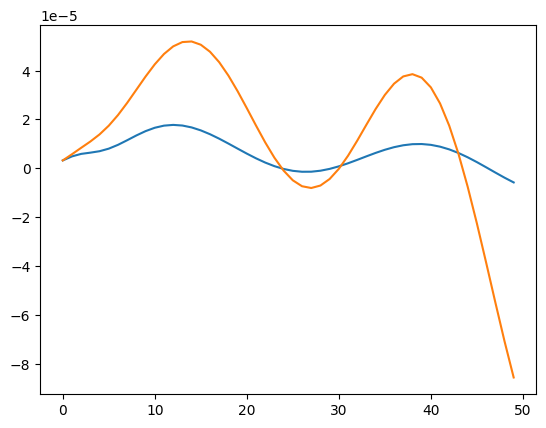

In [8]:
import matplotlib.pyplot as plt
plt.plot(S_list[0][:50] - S_hat_list[0][:50])

plt.plot(S_list[0][:50] - esn_fcast[0].detach().numpy())

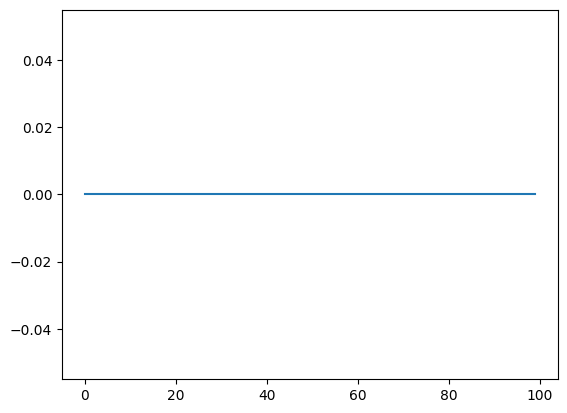

In [9]:
plt.plot(U_list[0])